### MSE - T-MachLe
# PW 06

{dorian.magnin, noemien.kocher}@master.hes-so.ch

## Exercice 1 Digit classification system using different SVM classifiers

### a. Getting the training and test sample sets from the MNIST database

#### a) Load MNIST digit dataset. Refer to : http://deeplearning.net/tutorial/gettingstarted.html.

In [3]:
import _pickle as cPickle, gzip, numpy
import pandas as pd

# Load the dataset
train_set, validation_set, test_set = pd.read_pickle("data/mnist.pkl.gz")

print(train_set)

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32), array([5, 0, 4, ..., 8, 4, 8]))


#### b) Visualize (plot) the image

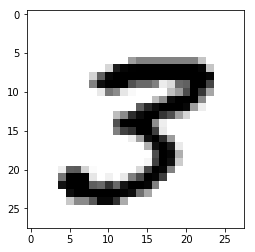

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# The rest of columns are pixels
pixels = train_set[0][203]

# Make those columns into a array of 8-bits pixels
# This array will be of 1D with length 784
# The pixel intensity values are integers from 0 to 255
pixels = np.array(pixels, dtype='float32')

# Reshape the array into 28 x 28 array (2-dimensional array)
pixels = pixels.reshape((28, 28))

plt.imshow(pixels, cmap='gray_r')
plt.show()


#### c) Build the final trainning and test set balanced

In [5]:
from collections import defaultdict
from numpy import random

def getBalabcedIndices(data, max=0):
    
    smallest_label_count = max
    if max == 0: 
        labels_count = defaultdict(int)
        # We find the minimum data items for a class
        for i in range(len(data[1])):
            label = data[1][i]
            labels_count[label] = labels_count[label] + 1
        smallest_label_count = labels_count[min(labels_count, key=labels_count.get)]
    
    indices_dict = defaultdict(list) # to keep trace of selected items
    indices = []
    
    # We won't iterate sequentially so we
    # maximise our chances to have sparse data
    lis = list(range(len(data[0])))
    random.shuffle(lis)
    for i in lis:
        label = data[1][i]
        if len(indices_dict[label]) < smallest_label_count:
            indices_dict[label].append(i)
            indices.append(i)
            
    # Quick test        
    for i in range(10):
        assert len(indices_dict[i]) == smallest_label_count
    assert len(indices) == smallest_label_count * 10
    print("Asserts Ok")
    
    return indices, smallest_label_count
    
train_balanced_indices, n1 = getBalabcedIndices(train_set, 200)
test_balanced_indices, n2 = getBalabcedIndices(test_set, 100)

print("Number per class for training set: ", n1)
print("Number per class for test set: ", n2)

def balancedTrainX():
    return [train_set[0][i] for i in train_balanced_indices]


def balancedTrainY():
    return [train_set[1][i] for i in train_balanced_indices]


def balancedTestX():
    return [test_set[0][i] for i in test_balanced_indices]


def balancedTestY():
    return [test_set[1][i] for i in test_balanced_indices]

#print(balancedTrainX())
#print(train_balanced_indices)

Asserts Ok
Asserts Ok
Number per class for training set:  200
Number per class for test set:  100


### b. Classification of digits based on raw pixel values using SVM and different kernels

Create, train and test several SVM classifiers with different kernels (linear, polynomial, RBF,...). For the training, perform a cross-validation using 10 folds, and test different with several C and kernel parameter values (e.g. for γ for RBF kernel) in order to get the best classifier. After the test, display the classification performances and confusion matrix of each SVM classifier (see class metrics):

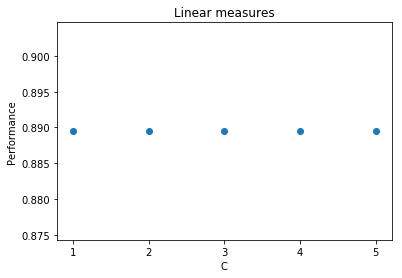

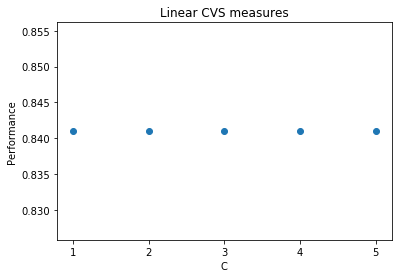

[[1.0, 1.0, 0.17750000000000002], [1.0, 2.0, 0.1265], [1.0, 3.0, 0.1135], [1.0, 4.0, 0.10900000000000001], [1.0, 5.0, 0.10800000000000001], [2.0, 1.0, 0.1875], [2.0, 2.0, 0.13900000000000001], [2.0, 3.0, 0.125], [2.0, 4.0, 0.11700000000000002], [2.0, 5.0, 0.11650000000000001], [3.0, 1.0, 0.1875], [3.0, 2.0, 0.13900000000000001], [3.0, 3.0, 0.125], [3.0, 4.0, 0.11700000000000002], [3.0, 5.0, 0.11650000000000001], [4.0, 1.0, 0.1875], [4.0, 2.0, 0.13900000000000001], [4.0, 3.0, 0.125], [4.0, 4.0, 0.11700000000000002], [4.0, 5.0, 0.11650000000000001], [5.0, 1.0, 0.1875], [5.0, 2.0, 0.13900000000000001], [5.0, 3.0, 0.125], [5.0, 4.0, 0.11700000000000002], [5.0, 5.0, 0.11650000000000001]]


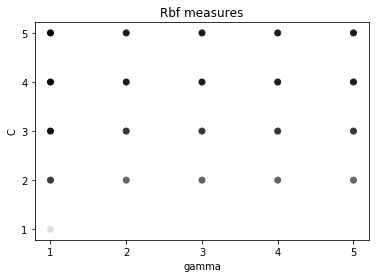

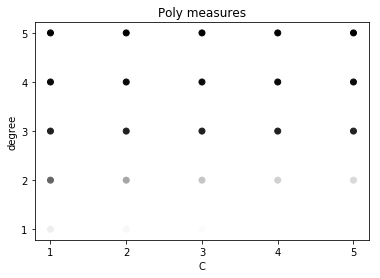

'\nmodels = (svm.SVC(kernel=\'linear\', C=C),\n          svm.LinearSVC(C=C),\n          svm.SVC(kernel=\'rbf\', gamma=0.7, C=C),\n          svm.SVC(kernel=\'poly\', degree=3, C=C))\n\nmodels = (clf.fit(balancedTrainX(), balancedTrainY()) for clf in models)\n\n\nfor clf in models:\n    print("Cross val score: ", np.mean(cross_val_score(clf, balancedTestX(), \n                                               balancedTestY(), \n                                               cv=fold_size)))\n'

In [47]:
from builtins import range

from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed
import concurrent.futures


fold_size = 10

C = 1.0  # SVM regularization parameter

Cs = np.arange(1, 6, 1, dtype='float')
gammas = np.arange(1, 6, 1, dtype='float')
degrees = np.arange(1, 6, 1, dtype='int')

linear_measures = []
linearCVS_measures = []
rbf_measures = []
poly_measures = []
'''
for c in Cs:
    # linear
    model = svm.SVC(kernel='linear', C=c)
    model.fit(balancedTrainX(), balancedTrainY())
    res = np.mean(cross_val_score(model, balancedTrainX(), 
                                               balancedTrainY(), 
                                               cv=fold_size))
    linear_measures.append(res)
    
    # linearCVS
    model = svm.LinearSVC(C=C)
    model.fit(balancedTrainX(), balancedTrainY())
    res = np.mean(cross_val_score(model, balancedTrainX(), 
                                               balancedTrainY(), 
                                               cv=fold_size))
    linearCVS_measures.append(res)
    
    # rbf
    res = []
    for gamma in gammas:
        model = svm.SVC(kernel='rbf', gamma=gamma, C=c)
        res.append(np.mean(cross_val_score(model, balancedTrainX(), 
                                               balancedTrainY(), 
                                               cv=fold_size)))
    rbf_measures.append(res)
    
    # poly
    res = []
    for degree in degrees:
        model = svm.SVC(kernel='poly', degree=degree, C=c)
        res.append(np.mean(cross_val_score(model, balancedTrainX(), 
                                               balancedTrainY(), 
                                               cv=fold_size)))
    poly_measures.append(res)
'''    


def f1(c):
    # linear

    model = svm.SVC(kernel='linear', C=c)
    model.fit(balancedTrainX(), balancedTrainY())
    res = np.mean(cross_val_score(model, balancedTrainX(), 
                                               balancedTrainY(), 
                                               cv=fold_size))
        
    return res


def f2(c):
    # linearCVS
    model = svm.LinearSVC(C=C)
    model.fit(balancedTrainX(), balancedTrainY())
    res = np.mean(cross_val_score(model, balancedTrainX(), 
                                               balancedTrainY(), 
                                               cv=fold_size))
    return res
    

def f3(c):
    # rbf
    res = []
    for gamma in gammas:
        model = svm.SVC(kernel='rbf', gamma=gamma, C=c)
        score = np.mean(cross_val_score(model, balancedTrainX(), 
                                               balancedTrainY(), 
                                               cv=fold_size))
        res.append([c, gamma, score])
    return res


def f4(c):
    # poly  
    res = []
    for degree in degrees:
        model = svm.SVC(kernel='poly', degree=degree, C=c)
        score = np.mean(cross_val_score(model, balancedTrainX(), 
                                               balancedTrainY(), 
                                               cv=fold_size))
        res.append([c, degree, score])
    return res


with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
    #future1 = executor.submit(f1)
    #future2 = executor.submit(f2)
    #future3 = executor.submit(f3)
    #future4 = executor.submit(f4)
    #linear_measures = future1.result()
    #linearCVS_measures = future2.result()
    #rbf_measures = future3.result()
    #poly_measures = future4.result()
    
    for c, res in zip(Cs, executor.map(f1, Cs)):
        linear_measures.append(res)
    
    for c, res in zip(Cs, executor.map(f2, Cs)):
        linearCVS_measures.append(res)

    for c, res in zip(Cs, executor.map(f3, Cs)):
        rbf_measures = rbf_measures + res

    for c, res in zip(Cs, executor.map(f4, Cs)):
        poly_measures = poly_measures + res

#print("Lin me: ", linear_measures)
#print("Poly me: ", poly_measures)

plt.scatter(Cs, linear_measures)
plt.title("Linear measures")
plt.xlabel("C")
plt.xticks(Cs)
plt.ylabel("Performance")
plt.show()

plt.scatter(Cs, linearCVS_measures)
plt.title("Linear CVS measures")
plt.xlabel("C")
plt.xticks(Cs)
plt.ylabel("Performance")
plt.show()

print(rbf_measures)

nm = len(rbf_measures)
plt.scatter( [rbf_measures[i][0] for i in range(nm)], [rbf_measures[i][1] for i in range(nm)], c=[rbf_measures[i][2] for i in range(nm)] )
plt.gray()
plt.title("Rbf measures")
plt.ylabel("C")
plt.yticks(Cs)
plt.xlabel("gamma")
plt.xticks(gammas)
plt.show()

nm = len(poly_measures)
plt.scatter( [poly_measures[i][0] for i in range(nm)], [poly_measures[i][1] for i in range(nm)], c=[poly_measures[i][2] for i in range(nm)] )
plt.gray()
plt.title("Poly measures")
plt.xlabel("C")
plt.xticks(Cs)
plt.ylabel("degree")
plt.yticks(degrees)
plt.show()

'''
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, C=C))

models = (clf.fit(balancedTrainX(), balancedTrainY()) for clf in models)


for clf in models:
    print("Cross val score: ", np.mean(cross_val_score(clf, balancedTestX(), 
                                               balancedTestY(), 
                                               cv=fold_size)))
'''

### d. Analysis of the results

Analyse the results obtained with the best SVM classifier.

a) Which kernel and parameters were used ?  
b) Which digit classes are the best/worse recognized against which ? Why ?  
c) What is the impact of the sizes of the training and test sets on the classification perfor- mance ?